# Original code example

In [1]:
import numpy as np
from scipy.special import digamma, polygamma

# convergence function
def is_convergence1(old, new, tol = 10**(-2)):
    """
    output:
    TRUR or FALSE
    """
    loss = np.sqrt(list(map(np.sum,np.square(old - new))))
    return np.max(loss) <= tol

def is_convergence2(old, new, tol = 10**(-2)):
    """
    output:
    TRUR or FALSE
    """
    loss = np.sqrt(np.sum(np.square(old - new)))
    return np.max(loss) <= tol

def optimize_vp(phi, gamma, alpha, beta, words, M, N, K, max_iter=500):
    '''
    optimize the variational parameter
    
    Parameters
    ----------
    phi:   ndarray
           An array of topic-word matrix
    gamma: ndarray
           A matrix of doc-topic
    alpha: ndarray
           the parameter of doc-topic dirichlet distribution
    beta:  ndarray
           the parameter of topic-word dirichlet distribution
    words: list 
           the list of lists of words in all 
    M : int, the number of documents
    N : ndarraay, the number of words in each document
    K : int, the number of topics in the corpus
    Returns
    -------
    out : list of ndarray
          the optimized and normalized(sum to 1) phi 
    '''
    
    for t in range(max_iter):
        phi_old = phi
        gamma_old = gamma
        #update phi
        for m in range(M):
            for n in range(N[m]):
                for i in range(K):
                    phi[m][n,i] = beta[i,np.int(words[m][n])] * np.exp(digamma(gamma[m,i]))
                #nomalize to 1)
                phi[m][n,:] = phi[m][n,:]/np.sum(phi[m][n,:])
        phi_new = phi
        #update gamma
        for i in range(M):
            gamma[i,:]  = alpha + np.sum(phi[i], axis = 0)
        gamma_new = gamma
        
        if is_convergence1(phi_old, phi_new) == True and is_convergence2(gamma_old, gamma_new) == True:
            break
   
    return phi, gamma

In [2]:
# estimate alpha
def alpha_estimate(gamma, alpha_initial, K, M, max_iter = 100):
    """
    This is an estimation function, especially used in the process of LDA algorithm.
    digamma function and polygamma function are used in the following process.
    
    input:
    alpha_initial: the initial setting of alpha, it is an 1*K vector
    K: the number of topics
    M: the number of documents
    gamma: the result from another update function (see gamma_update())
    """
    from scipy.special import digamma, polygamma
    
    alpha = alpha_initial
    for t in range(max_iter):
        alpha_old = alpha
        
        # compute the gradient vector and the diagonal part of the Hessian matrix
        g = np.zeros(K)
        h = np.zeros(K)
        for i in range(K):
            g1 = M*(digamma(np.sum(alpha))-digamma(alpha[i]))
            g2 = 0
            for d in range(M):
                g2 += digamma(gamma[d,i])-digamma(np.sum(gamma[d,:]))
            g[i] = g1 + g2
            
            h[i] = -M*polygamma(1, alpha[i])
        
        # compute the constant part
        z = M*polygamma(1, np.sum(alpha))
        c = (np.sum(g/h))/(z**(-1) + np.sum(h**(-1)))
                           
        # update alpha                   
        alpha -= (g-c)/h
        
        if is_convergence2(alpha_old, alpha):
            break
            
    return alpha

In [3]:
# estimate beta
def beta_estimate(K, V_words, phi, D):
    
    """
    This is an estimation function, especially used in the process of LDA algorithm
    
    input:
    K: the number of topics
    V_words: a vector of all unique words in the vocabulary
    D: D = (w_1,w_2,...w_M), contains all words in all documents
    phi: the result from another update function (see phi_update())
    
    output:
    beta: the estimate parameter for LDA, it is a K*V matrix
    """
    V = len(V_words)
    beta = np.ones((K,V))
    # first obtain the propotion values
    for j in range(V):
        word = V_words[j]
        # give a TRUE or FALSE "matrix", remember w_mnj should have the same shape with phi
        w_mnj = [np.repeat(w==word, K).reshape((len(w),K)) for w in D]
        # compute the inner sum over number of words
        sum1 = list(map(lambda x: np.sum(x,axis=0),phi*w_mnj))
        # compute the outer sum over documents
        beta[:,j] = np.sum(np.array(sum1), axis = 0)
    
    # then normalize each row s.t. the row sum is one
    for i in range(K):
        beta[i,:] = beta[i,:]/sum(beta[i,:])
        
    return beta

In [4]:
import numpy as np
from scipy.special import digamma, polygamma

In [5]:
# Variation EM
def variation_EM(M, K, D, N, V_words, alpha_initial, beta_initial, gamma_initial, phi_initial, iteration = 1000):
    
    phi_gamma = optimize_vp(phi_initial, gamma_initial, alpha_initial, beta_initial, w_struct, M, N, K)
    phi = phi_gamma[0]
    gamma = phi_gamma[1]
    
     
    (alpha, beta) = (alpha_initial, beta_initial)
    
    for t in range(iteration):
        
        (phi_old, gamma_old) = (phi, gamma)
        
        alpha = alpha_estimate(gamma, alpha, K, M)
        beta = beta_estimate(K, V_words, phi, D)
        
        phi_gamma1 = optimize_vp(phi, gamma, alpha, beta, D, M, N, K)
        phi = phi_gamma1[0]
        gamma = phi_gamma1[1]
        
        if is_convergence2(gamma_old, gamma) and is_convergence1(phi_old, phi):
            break
    
    return alpha, beta, gamma, phi

In [6]:
np.random.seed(1337)

M = 300
k = 10
N = np.random.randint(150,200,size=M)
V = 30

# Create 3 groups of documents, each with a topic preference
alpha_gen1 = np.array((20,15,10,1,1,1,1,1,1,1))
alpha_gen2 = np.array((1,1,1,10,15,20,1,1,1,1))
alpha_gen3 = np.array((1,1,1,1,1,1,10,12,15,18))

# Arbitrarily choose each topic to have 3 very common words
beta_probs = np.ones((V,k)) + np.array([np.arange(V)%k==i for i in range(k)]).T*19
beta_gen = np.array(list(map(lambda x: np.random.dirichlet(x),beta_probs.T))).T

w_struct = list();
theta = np.empty((M,k))

# Generate each document
for m in range(M):
    # Draw topic distribution for the document
    if m<M/3:
        theta[m,:] = np.random.dirichlet(alpha_gen1,1)[0]
    elif m<2*M/3:
        theta[m,:] = np.random.dirichlet(alpha_gen2,1)[0]
    else:
        theta[m,:] = np.random.dirichlet(alpha_gen3,1)[0]
    doc = np.array([])
    
    for n in range(N[m]):
        # Draw topic according to document's topic distribution
        z_n = np.random.choice(np.arange(k),p=theta[m,:])
        # Draw word according to topic
        w_n = np.random.choice(np.arange(V),p=beta_gen[:,z_n])
        doc = np.append(doc,w_n)
    w_struct.append(doc)

In [7]:
V_words = range(30)
alpha = np.random.dirichlet(10*np.ones(k),1)[0]
beta = np.random.dirichlet(np.ones(V),k)

phi = np.array([1/k*np.ones([N[m],k]) for m in range(M)])
gamma = np.tile(alpha,(M,1)) + np.tile(N/k,(k,1)).T

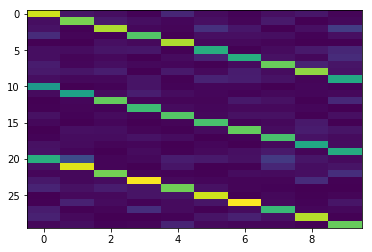

In [12]:
import matplotlib.pyplot as plt
plt.imshow(beta_gen, interpolation='nearest', aspect='auto')


In [9]:
ans = variation_EM(M, k, w_struct, N, V_words, alpha, beta, gamma, phi, iteration = 1000)

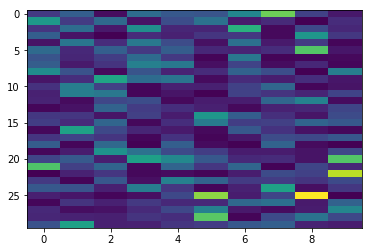

In [10]:
plt.imshow(ans[1].T,interpolation='nearest', aspect='auto')

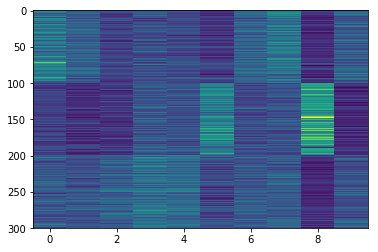

In [11]:
plt.imshow(ans[2], interpolation='nearest', aspect='auto')

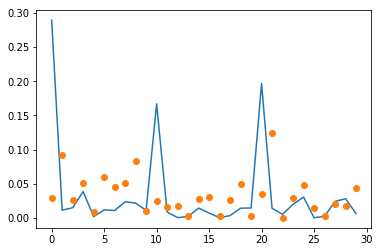

In [24]:
plt.plot(beta_gen[:,0])
plt.plot(ans[1].T[:,0], "o")

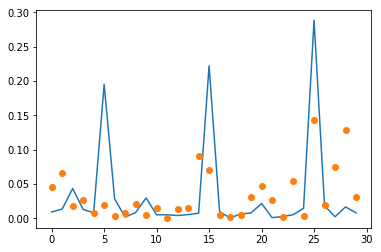

In [18]:
plt.plot(beta_gen[:,5])
plt.plot(ans[1].T[:,5], "o")

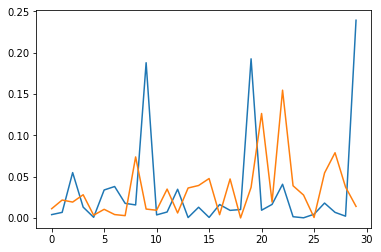

In [72]:
plt.plot(beta_gen[:,9])
plt.plot(ans[1].T[:,9])

# Optimazed code example

In [25]:
# a new function to calculate log of sum
def log_sum(log_a, log_b):
    """
    input: log(a), log(b)
    output: log(a+b)
    """
    return log_a + np.log(1+np.exp(log_b - log_a))



def optimize_vp_opt(phi, gamma, alpha, beta, words, M, N, K, max_iter=500):
    '''
    optimize the variational parameter
    
    Parameters
    ----------
    phi:   ndarray
           An array of topic-word matrix
    gamma: ndarray
           A matrix of doc-topic
    alpha: ndarray
           the parameter of doc-topic dirichlet distribution
    beta:  ndarray
           the parameter of topic-word dirichlet distribution
    words: list 
           the list of lists of words in all 
    M : int, the number of documents
    N : ndarraay, the number of words in each document
    K : int, the number of topics in the corpus
    Returns
    -------
    out : list of ndarray
          the optimized and normalized(sum to 1) phi 
    '''
    
    for t in range(max_iter):
        phi_old = phi
        
        # we use log(phi) here and following processes
        log_phi = np.array(list(map(np.log, phi)))
        gamma_old = gamma
       
        for m in range(M):
            for n in range(N[m]):
                
                logsum = 0
                for i in range(K):
                    
                    # use new method in log form to update phi
                    log_phi[m][n,i] = np.log(beta[i,np.int(words[m][n])]) + digamma(gamma[m,i])
                    
                    logsum = log_sum(logsum, log_phi[m][n,i])
                # use new metohd to implement nomalization
                log_phi_mn = log_phi[m][n,:] - logsum
                log_phi[m][n,:] = log_phi_mn
                
                phi[m][n,:] = np.exp(log_phi_mn)
        
            # instead of alpha, use old phi and new phi to iterative
            d_phi = phi[m] - phi_old[m]
            gamma[m,:]  = gamma[m,:] + np.sum(d_phi, axis = 0)
            
        phi_new = phi
        gamma_new = gamma
        
        if is_convergence1(phi_old, phi_new) == True and is_convergence2(gamma_old, gamma_new) == True:
            break
   
    return phi, gamma


In [26]:

# estimate alpha
def alpha_estimate_opt(gamma, alpha_initial, K, M, max_iter = 100):
    """
    This is an estimation function, especially used in the process of LDA algorithm.
    digamma function and polygamma function are used in the following process.
    
    input:
    alpha_initial: the initial setting of alpha, it is an 1*K vector
    K: the number of topics
    M: the number of documents
    gamma: the result from another update function (see gamma_update())
    """
    from scipy.special import digamma, polygamma
    
    alpha = alpha_initial
    for t in range(max_iter):
        alpha_old = alpha
        
        # we use vector instead of calculating in loop
        g = M*(digamma(np.sum(alpha))-digamma(alpha)) 
        + np.sum(digamma(gamma) -np.tile(digamma(np.sum(gamma,axis=1)),(K,1)).T,axis=0)
        h = -M*polygamma(1,alpha)
        
        z = M*polygamma(1, np.sum(alpha))
        c = (np.sum(g/h))/(z**(-1) + np.sum(h**(-1)))
                           
        # update alpha                   
        alpha -= (g-c)/h
        
        if is_convergence2(alpha_old, alpha):
            break
            
    return alpha


In [27]:
# estimate beta
def beta_estimate_opt(K, V_words, phi, D):
    
    """
    This is an estimation function, especially used in the process of LDA algorithm
    
    input:
    K: the number of topics
    V_words: a vector of all unique words in the vocabulary
    D: D = (w_1,w_2,...w_M), contains all words in all documents
    phi: the result from another update function (see phi_update())
    
    output:
    beta: the estimate parameter for LDA, it is a K*V matrix
    """
    V = len(V_words)
    beta = np.ones((K,V))
    # first obtain the propotion values
    for j in range(V):
        word = V_words[j]
        # give a TRUE or FALSE "matrix", remember w_mnj should have the same shape with phi
        w_mnj = [np.repeat(w==word, K).reshape((len(w),K)) for w in D]
        # compute the inner sum over number of words
        sum1 = list(map(lambda x: np.sum(x,axis=0),phi*w_mnj))
        # compute the outer sum over documents
        beta[:,j] = np.sum(np.array(sum1), axis = 0)
    
    # then normalize each row s.t. the row sum is one, in vector method
    beta= beta/ np.sum(beta, axis = 1).reshape((-1,1))
        
    return beta


In [28]:
# Optimize variation EM
def variation_EM_new(M, K, D, N, V_words, alpha_initial, beta_initial, gamma_initial, phi_initial, iteration = 1000):
    
    phi_gamma = optimize_vp_opt(phi_initial, gamma_initial, alpha_initial, beta_initial, w_struct, M, N, K)
    phi = phi_gamma[0]
    gamma = phi_gamma[1]
    
     
    (alpha, beta) = (alpha_initial, beta_initial)
    
    for t in range(iteration):
        
        (phi_old, gamma_old) = (phi, gamma)
        
        alpha = alpha_estimate_opt(gamma, alpha, K, M)
        beta = beta_estimate_opt(K, V_words, phi, D)
        
        phi_gamma1 = optimize_vp_opt(phi, gamma, alpha, beta, D, M, N, K)
        phi = phi_gamma1[0]
        gamma = phi_gamma1[1]
        
        if is_convergence2(gamma_old, gamma) and is_convergence1(phi_old, phi):
            break
    
    return alpha, beta, gamma, phi


In [29]:
V_words = range(30)
alpha = np.random.dirichlet(10*np.ones(k),1)[0]
beta = np.random.dirichlet(np.ones(V),k)

phi = np.array([1/k*np.ones([N[m],k]) for m in range(M)])
gamma = np.tile(alpha,(M,1)) + np.tile(N/k,(k,1)).T

In [30]:
ans1 = variation_EM_new(M, k, w_struct, N, V_words, alpha, beta, gamma, phi, iteration = 1000)

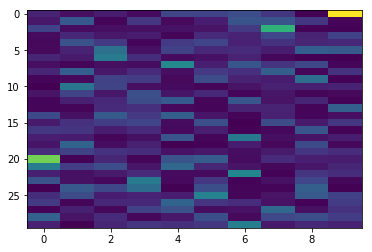

In [31]:
plt.imshow(ans1[1].T,interpolation='nearest', aspect='auto')

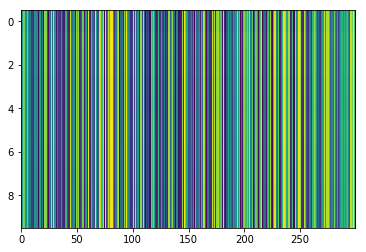

In [32]:
plt.imshow(ans1[2].T,interpolation='nearest', aspect='auto') #aaaaa why!!!!

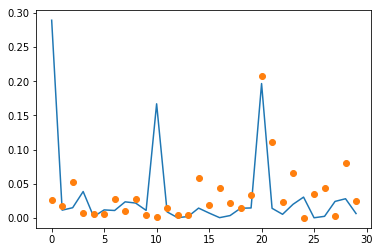

In [41]:
plt.plot(beta_gen[:,0])
plt.plot(ans1[1].T[:,0], "o")

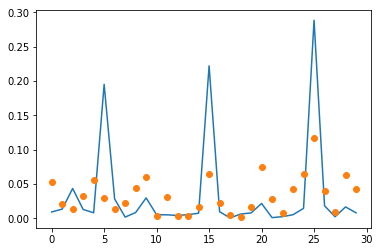

In [50]:
plt.plot(beta_gen[:,5])
plt.plot(ans1[1].T[:,5], "o")

# Real world data

In [ ]:
# pip install nltk
# pip install stop-words
# easy_install -U gensim

In [61]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
    
# create sample documents
doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
doc_e = "Health professionals say that brocolli is good for your health." 

# compile sample documents into a list
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

In [62]:
# LDA
print(ldamodel.print_topics(num_topics=2, num_words=4))


[(0, '0.068*"mother" + 0.068*"brother" + 0.067*"brocolli" + 0.067*"good"'), (1, '0.060*"health" + 0.058*"pressur" + 0.058*"drive" + 0.057*"caus"')]


In [68]:
#LSI
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=1000)

In [70]:
print(lsi.print_topics(num_topics=2, num_words=4))


[(0, '0.424*"brocolli" + 0.424*"good" + 0.350*"eat" + 0.346*"brother"'), (1, '0.376*"drive" + -0.349*"good" + -0.349*"brocolli" + 0.285*"pressur"')]
